# Final Project: Predicting LinkedIn Users with Machine Learning
## Phoebe Lamb
### December 2025

***

## Part 1: Building a Classification Model

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

***

#### Q1: Read in the data and check dimensions

In [2]:
# Reading in the social media usage data.
# This dataset contains information about social media usage and demographics.

s = pd.read_csv('social_media_usage.csv')
s.shape

(1502, 89)

In [3]:
# Checking the first few rows to see what the data looks like
s.head()

,respid,sample,comp,int_date,lang,state,density,usr,qs1,sex,...,income,party,partyln,hh1,hh3,ql1,ql1a,qc1,weight,cellweight
0,798,1,1,1/26/2021,1,51,5,S,,2,...,6,2,,1,,1,,,0.557187,
1,1017,1,1,1/25/2021,1,39,2,S,,1,...,5,1,,2,2,1,,,0.987209,
2,1181,1,1,1/25/2021,1,32,2,U,,2,...,8,3,2,2,2,1,,,0.925147,
3,1388,1,1,1/25/2021,1,4,3,U,,1,...,8,2,,1,,1,,,0.311080,
4,1664,1,1,1/26/2021,1,12,2,S,,2,...,7,2,,2,2,1,,,0.396548,


***

#### Q2: Define clean_sm function

In [4]:
# Creating a function to clean social media usage variables.
# This function uses np.where to convert values to binary (1 if the value is 1, otherwise 0).
# This is helpful because the data codes "Yes" as 1 and "No" as 2,
# but for machine learning we want 1 for Yes and 0 for No.

def clean_sm(x):
    x = np.where(x == 1, 1, 0)
    return x

In [5]:
# Testing the function with a toy dataframe to make sure it works correctly
test_df = pd.DataFrame({'col1': [1, 2, 1], 'col2': [2, 1, 2]})
print("Original test dataframe:")
print(test_df)

print("\nAfter applying clean_sm to col1:")
test_df['col1_cleaned'] = clean_sm(test_df['col1'])
print(test_df)

Original test dataframe:
   col1  col2
0     1     2
1     2     1
2     1     2

After applying clean_sm to col1:
   col1  col2  col1_cleaned
0     1     2             1
1     2     1             0
2     1     2             1


***

#### Q3: Create cleaned dataframe (ss) with target and features

In [6]:
# Creating a new dataframe with only the variables I need for the model.
# Starting by selecting the relevant columns from the original data.

ss = s[['web1h', 'income', 'educ2', 'par', 'marital', 'gender', 'age']].copy()

# Creating the target variable sm_li (whether person uses LinkedIn)
# Using the clean_sm function to convert to binary
ss['sm_li'] = clean_sm(ss['web1h'])

# Creating binary parent variable (1 if parent, 0 if not)
ss['parent'] = np.where(ss['par'] == 1, 1, 0)

# Creating binary married variable (1 if married, 0 if not)
ss['married'] = np.where(ss['marital'] == 1, 1, 0)

# Creating binary female variable (1 if female, 0 if not)
ss['female'] = np.where(ss['gender'] == 2, 1, 0)

# Checking the dataframe
ss.head()

,web1h,income,educ2,par,marital,gender,age,sm_li,parent,married,female
0,2,6,4,2,5,2,77,0,0,0,1
1,2,5,3,2,6,1,59,0,0,0,0
2,2,8,4,2,1,2,60,0,0,1,1
3,2,8,8,2,6,1,73,0,0,0,0
4,1,7,8,2,1,2,65,1,0,1,1


In [7]:
# Cleaning the data by removing missing values.
# Setting income > 9 to missing, education > 8 to missing, and age > 98 to missing.

ss['income'] = np.where(ss['income'] > 9, np.nan, ss['income'])
ss['educ2'] = np.where(ss['educ2'] > 8, np.nan, ss['educ2'])
ss['age'] = np.where(ss['age'] > 98, np.nan, ss['age'])

# Dropping rows with any missing values
ss = ss.dropna()

# Keeping only the columns I need for modeling
ss = ss[['sm_li', 'income', 'educ2', 'parent', 'married', 'female', 'age']]

print(f"Shape after cleaning: {ss.shape}")
ss.head()

Shape after cleaning: (1260, 7)


,sm_li,income,educ2,parent,married,female,age
0,0,6.0,4.0,0,0,1,77.0
1,0,5.0,3.0,0,0,0,59.0
2,0,8.0,4.0,0,1,1,60.0
3,0,8.0,8.0,0,0,0,73.0
4,1,7.0,8.0,0,1,1,65.0


In [8]:
# Checking summary statistics to understand the data
ss.describe()

,sm_li,income,educ2,parent,married,female,age
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,0.333333,5.865873,5.203175,0.249206,0.483333,0.419841,51.253968
std,0.471592,2.474385,1.877501,0.432725,0.499921,0.493729,18.403705
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,18.000000
25%,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,36.000000
50%,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,52.000000
75%,1.000000,8.000000,6.000000,0.000000,1.000000,1.000000,65.000000
max,1.000000,9.000000,8.000000,1.000000,1.000000,1.000000,97.000000


In [9]:
# Looking at LinkedIn usage by different groups

print("LinkedIn usage by parent status:")
print(ss.groupby('parent')['sm_li'].mean())

print("\nLinkedIn usage by marital status:")
print(ss.groupby('married')['sm_li'].mean())

print("\nLinkedIn usage by gender:")
print(ss.groupby('female')['sm_li'].mean())

LinkedIn usage by parent status:
parent
0    0.305497
1    0.417197
Name: sm_li, dtype: float64

LinkedIn usage by marital status:
married
0    0.294931
1    0.374384
Name: sm_li, dtype: float64

LinkedIn usage by gender:
female
0    0.363885
1    0.291115
Name: sm_li, dtype: float64


income
1.0    0.101449
2.0    0.131313
3.0    0.149533
4.0    0.243697
5.0    0.215909
6.0    0.198895
7.0    0.439791
8.0    0.484211
9.0    0.574074
Name: sm_li, dtype: float64


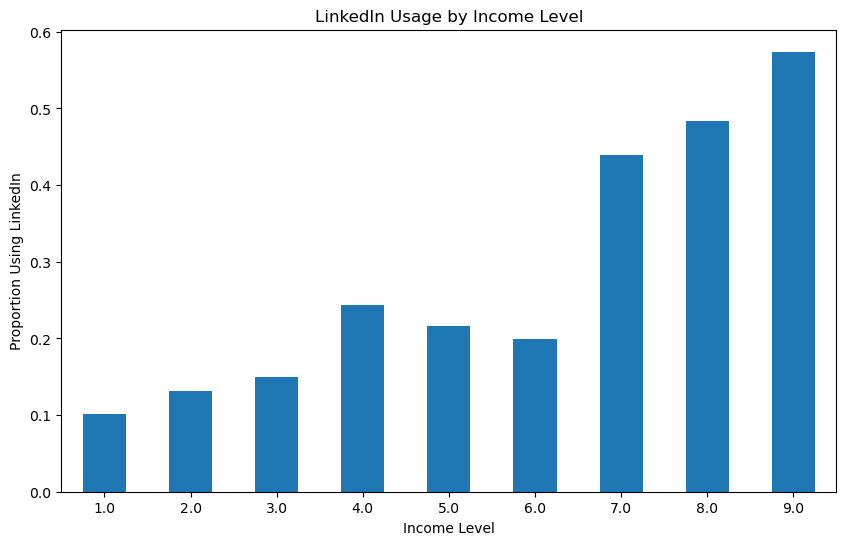

In [10]:
# Looking at how income relates to LinkedIn usage
income_usage = ss.groupby('income')['sm_li'].mean()
print(income_usage)

# Visualizing this relationship
plt.figure(figsize=(10, 6))
income_usage.plot(kind='bar')
plt.title('LinkedIn Usage by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Proportion Using LinkedIn')
plt.xticks(rotation=0)
plt.show()

educ2
1.0    0.000000
2.0    0.025641
3.0    0.116000
4.0    0.264423
5.0    0.303704
6.0    0.472892
7.0    0.617647
8.0    0.469636
Name: sm_li, dtype: float64


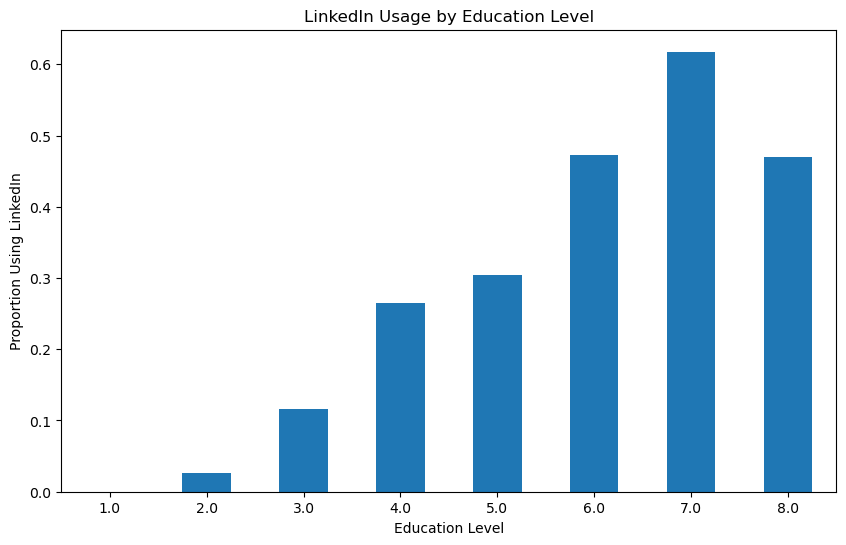

In [11]:
# Looking at how education relates to LinkedIn usage
educ_usage = ss.groupby('educ2')['sm_li'].mean()
print(educ_usage)

# Visualizing this relationship
plt.figure(figsize=(10, 6))
educ_usage.plot(kind='bar')
plt.title('LinkedIn Usage by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Proportion Using LinkedIn')
plt.xticks(rotation=0)
plt.show()

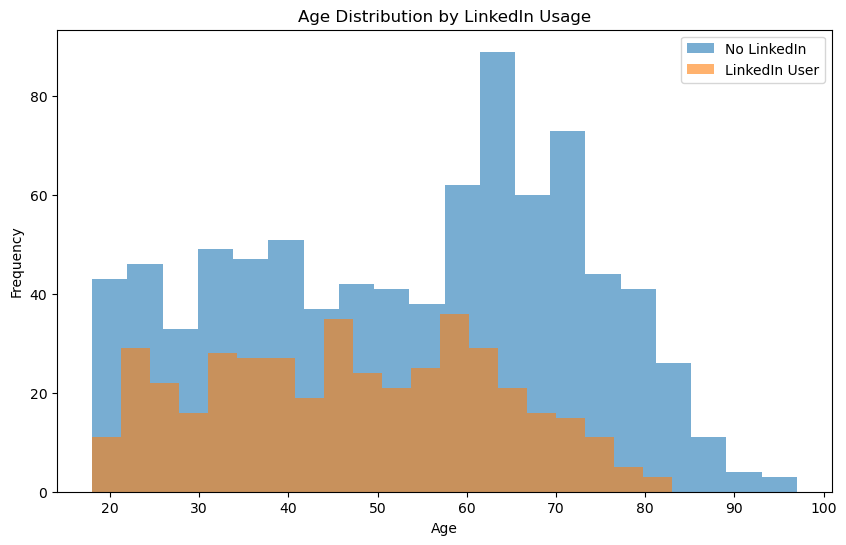


Age by LinkedIn usage:
       count       mean        std   min   25%   50%   75%   max
sm_li                                                           
0      840.0  53.325000  19.248958  18.0  37.0  56.0  69.0  97.0
1      420.0  47.111905  15.810765  18.0  34.0  47.0  60.0  83.0


In [12]:
# Visualizing age distribution by LinkedIn usage
# Using overlapping histograms like in ML I project

plt.figure(figsize=(10, 6))
plt.hist(ss[ss['sm_li']==0]['age'], bins=20, alpha=0.6, label='No LinkedIn')
plt.hist(ss[ss['sm_li']==1]['age'], bins=20, alpha=0.6, label='LinkedIn User')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution by LinkedIn Usage')
plt.legend()
plt.show()

print("\nAge by LinkedIn usage:")
print(ss.groupby('sm_li')['age'].describe())

LinkedIn usage distribution:
sm_li
0    840
1    420
Name: count, dtype: int64


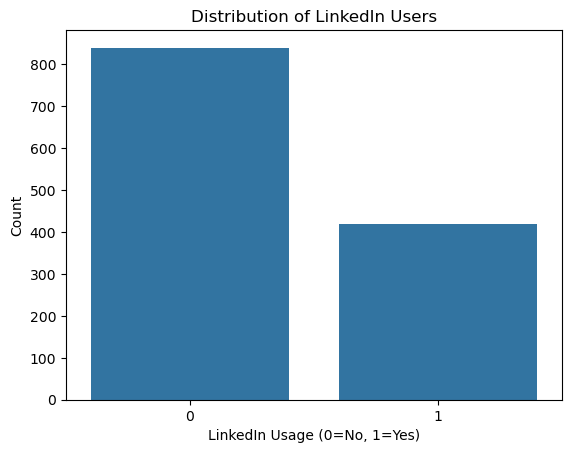

In [13]:
# Checking the distribution of LinkedIn users vs non-users
# This shows if we have a class imbalance

print("LinkedIn usage distribution:")
print(ss['sm_li'].value_counts())

# Visualizing the distribution
sns.countplot(data=ss, x='sm_li')
plt.xlabel('LinkedIn Usage (0=No, 1=Yes)')
plt.ylabel('Count')
plt.title('Distribution of LinkedIn Users')
plt.show()

***

#### Q4: Create target vector (y) and feature set (X)

In [14]:
# Creating the target variable y (what we want to predict) and features X (what we use to predict).
# y is the LinkedIn usage indicator (sm_li)
# X contains all the features: income, education, parent status, marital status, gender, and age

y = ss['sm_li']
X = ss[['income', 'educ2', 'parent', 'married', 'female', 'age']]

print(f"Target variable shape: {y.shape}")
print(f"Features shape: {X.shape}")

Target variable shape: (1260,)
Features shape: (1260, 6)


***

#### Q5: Split data into training and test sets

In [15]:
# Splitting the data into training and testing sets.
# I'm holding out 20% of the data for testing (test_size=0.2).
# The training set is used to teach the model patterns,
# and the test set is used to evaluate how well the model performs on new, unseen data.
# Using random_state=42 so the split is reproducible.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (1008, 6)
Testing features shape: (252, 6)
Training target shape: (1008,)
Testing target shape: (252,)


**Explanation of each object:**

- **X_train**: The features (income, education, etc.) used to train the model. The model learns patterns from this data.
- **X_test**: The features used to test the model. This data is "held out" and not seen during training.
- **y_train**: The actual LinkedIn usage outcomes for the training data. The model learns to predict these.
- **y_test**: The actual LinkedIn usage outcomes for the test data. Used to check if the model's predictions are accurate.

The split helps us evaluate whether the model generalizes well to new data, not just memorizes the training data.

***

#### Q6: Instantiate and fit logistic regression model

In [16]:
# Creating a logistic regression model.
# Setting class_weight='balanced' to handle the imbalance in LinkedIn users vs non-users.
# This gives more weight to the minority class so the model doesn't just predict "non-user" all the time.

lr = LogisticRegression(class_weight='balanced', random_state=42)

# Fitting the model with the training data
# This is where the model learns the relationship between features and LinkedIn usage
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

***

#### Q7: Evaluate model and create confusion matrix

In [17]:
# Using the model to make predictions on the test data
y_pred = lr.predict(X_test)

# Calculating the accuracy score
# Accuracy is the proportion of correct predictions out of all predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print(f"This means the model correctly predicts LinkedIn usage {accuracy*100:.2f}% of the time.")

Model Accuracy: 0.6587
This means the model correctly predicts LinkedIn usage 65.87% of the time.


In [18]:
# Creating a confusion matrix to see where the model makes correct and incorrect predictions
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[99 62]
 [24 67]]


**Interpreting the confusion matrix:**

The confusion matrix shows four numbers:
- **Top-left (True Negatives)**: People who don't use LinkedIn that the model correctly predicted as non-users
- **Top-right (False Positives)**: People who don't use LinkedIn but the model incorrectly predicted as users
- **Bottom-left (False Negatives)**: People who use LinkedIn but the model incorrectly predicted as non-users
- **Bottom-right (True Positives)**: People who use LinkedIn that the model correctly predicted as users

***

#### Q8: Create confusion matrix as dataframe

In [19]:
# Creating a confusion matrix as a dataframe with labels
# This makes it easier to see what each number represents

pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns=["Predicted: No LinkedIn", "Predicted: LinkedIn User"],
            index=["Actual: No LinkedIn","Actual: LinkedIn User"])

,Predicted: No LinkedIn,Predicted: LinkedIn User
Actual: No LinkedIn,99,62
Actual: LinkedIn User,24,67


***

#### Q9: Calculate precision, recall, and F1 score by hand

In [20]:
# Extracting values from confusion matrix to calculate metrics by hand
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives
TP = cm[1, 1]  # True Positives

print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")

True Negatives: 99
False Positives: 62
False Negatives: 24
True Positives: 67


In [21]:
# Calculating Precision by hand
# Precision = TP / (TP + FP)
# Precision tells us: of all the people we predicted use LinkedIn, how many actually do?
# This is important when false positives are costly - like wasting marketing budget on wrong targets.

precision = TP / (TP + FP)
print(f"Precision (calculated by hand): {precision:.4f}")
print(f"This means {precision*100:.2f}% of people we predict as LinkedIn users actually use it.")

Precision (calculated by hand): 0.5194
This means 51.94% of people we predict as LinkedIn users actually use it.


In [22]:
# Calculating Recall by hand
# Recall = TP / (TP + FN)
# Recall tells us: of all the people who actually use LinkedIn, how many did we correctly identify?
# This is important when false negatives are costly - like missing potential customers.

recall = TP / (TP + FN)
print(f"Recall (calculated by hand): {recall:.4f}")
print(f"This means we correctly identify {recall*100:.2f}% of actual LinkedIn users.")

Recall (calculated by hand): 0.7363
This means we correctly identify 73.63% of actual LinkedIn users.


In [23]:
# Calculating F1 Score by hand
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
# F1 score is the harmonic mean of precision and recall.
# It's useful when you want a single metric that balances both precision and recall.
# This is important when both false positives and false negatives matter equally.

f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score (calculated by hand): {f1:.4f}")

F1 Score (calculated by hand): 0.6091


**When to use each metric:**

- **Precision**: Use when false positives are costly. Example: Email spam filter - you don't want important emails marked as spam.

- **Recall**: Use when false negatives are costly. Example: Cancer screening - you don't want to miss people who have cancer.

- **F1 Score**: Use when you need to balance precision and recall. Example: Fraud detection - both missing fraud (FN) and flagging legitimate transactions (FP) are problematic.

In [24]:
# Verifying calculations with sklearn's classification report
print("Classification Report from sklearn:")
print(classification_report(y_test, y_pred))

print("\nMy hand-calculated metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report from sklearn:
              precision    recall  f1-score   support

           0       0.80      0.61      0.70       161
           1       0.52      0.74      0.61        91

    accuracy                           0.66       252
   macro avg       0.66      0.68      0.65       252
weighted avg       0.70      0.66      0.67       252


My hand-calculated metrics:
Precision: 0.5194
Recall: 0.7363
F1 Score: 0.6091


***

#### Q10: Make predictions for specific individuals

In [25]:
# Making a prediction for a 42-year-old person:
# High income (8), high education (7), not a parent (0), married (1), female (1), age 42

person1 = pd.DataFrame([[8, 7, 0, 1, 1, 42]], 
                       columns=['income', 'educ2', 'parent', 'married', 'female', 'age'])

# Getting the probability that this person uses LinkedIn
prob1 = lr.predict_proba(person1)[0][1]

print(f"Person 1 (42 years old):")
print(f"Probability of using LinkedIn: {prob1:.4f} ({prob1*100:.2f}%)")
print(f"Prediction: {'LinkedIn User' if prob1 >= 0.5 else 'Not a LinkedIn User'}")

Person 1 (42 years old):
Probability of using LinkedIn: 0.7419 (74.19%)
Prediction: LinkedIn User


In [26]:
# Making a prediction for an 82-year-old person with the same other characteristics:
# High income (8), high education (7), not a parent (0), married (1), female (1), age 82

person2 = pd.DataFrame([[8, 7, 0, 1, 1, 82]], 
                       columns=['income', 'educ2', 'parent', 'married', 'female', 'age'])

# Getting the probability that this person uses LinkedIn
prob2 = lr.predict_proba(person2)[0][1]

print(f"Person 2 (82 years old):")
print(f"Probability of using LinkedIn: {prob2:.4f} ({prob2*100:.2f}%)")
print(f"Prediction: {'LinkedIn User' if prob2 >= 0.5 else 'Not a LinkedIn User'}")

Person 2 (82 years old):
Probability of using LinkedIn: 0.4720 (47.20%)
Prediction: Not a LinkedIn User


In [27]:
# Comparing the two predictions
print(f"\nComparison:")
print(f"42-year-old: {prob1*100:.2f}% probability")
print(f"82-year-old: {prob2*100:.2f}% probability")
print(f"\nDifference: {(prob1-prob2)*100:.2f} percentage points")
print(f"\nThe older person has a lower probability of using LinkedIn,")
print(f"which makes sense as younger people tend to be more active on social media platforms.")


Comparison:
42-year-old: 74.19% probability
82-year-old: 47.20% probability

Difference: 26.99 percentage points

The older person has a lower probability of using LinkedIn,
which makes sense as younger people tend to be more active on social media platforms.


***